# Bagging 분류

개별적으로 수행된 알고리즘 중에서 최적의 알고리즘에 대해 샘플을 여러 번 뽑아(Bootstrap) 각 모델을 학습시켜 결과물을 집계(Aggregation)하는 방법.

우선적으로 주어진 데이터에 적합한 최적의 모델을 선정해야 한다.

Votting의 결과도 Bagging의 대상이 될 수 있으며 Bagging의 결과도 Votting의 대상이 될 수 있지만 머신 성능의 문제로 잘 사용되지는 않는다.

## #01. 준비작업

### [1] 패키지 가져오기

In [14]:
# 연결된 모듈이 업데이트 되면 즉시 자동 로드함
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings(action='ignore')

from hossam.util import *
from hossam.plot import *
from hossam.analysis import *
from hossam.classification import *

# 배깅 앙상블
from sklearn.ensemble import BaggingClassifier

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### [2] 데이터 가져오기 + 전처리

`0`값을 포함해서는 안되는 변수에 대해 평균으로 대체

In [15]:
origin = my_read_excel("https://data.hossam.kr/mldata/pima_indians_diabetes.xlsx", categories=['Outcome'], info=False)

# 정제 대상 필드명
zero_features = ['Glucose', 'BloodPressure','SkinThickness','Insulin','BMI']

# 0값을 결측치로 대체후 평균으로 다시 치환
df = origin.copy()
df[zero_features] = df[zero_features].replace(0, np.nan)
df2 = my_replace_missing_value(df)

# 결과확인
total_count = len(origin)

for feature in zero_features:
    zero_count = origin[origin[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))

print("---" * 30)

for feature in zero_features:
    zero_count = df2[df2[feature] == 0][feature].count()
    print('{0} 0 건수는 {1}, 퍼센트는 {2:.2f} %'.format(feature, zero_count, 100*zero_count/total_count))


상위 5개 행
+----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------+
|    |   Pregnancies |   Glucose |   BloodPressure |   SkinThickness |   Insulin |   BMI |   DiabetesPedigreeFunction |   Age |   Outcome |
|----+---------------+-----------+-----------------+-----------------+-----------+-------+----------------------------+-------+-----------|
|  0 |             6 |       148 |              72 |              35 |         0 |  33.6 |                      0.627 |    50 |         1 |
|  1 |             1 |        85 |              66 |              29 |         0 |  26.6 |                      0.351 |    31 |         0 |
|  2 |             8 |       183 |              64 |               0 |         0 |  23.3 |                      0.672 |    32 |         1 |
|  3 |             1 |        89 |              66 |              23 |        94 |  28.1 |                      0.167 |    21 |         0 |
|  4 |     

### [3] 훈련/검증 데이터 분할 및 데이터 표준화

In [16]:
x_train, x_test, y_train, y_test = my_train_test_split(df2, 'Outcome', scalling=True)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((614, 8), (154, 8), (614,), (154,))

## #02. 기본 Bagging

### [1] 이 데이터에 대한 최적 모형 찾기

가지치기를 하지 않습니다.
+------------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------+
|                        |   의사결정계수(Pseudo R2) |   정확도(Accuracy) |   정밀도(Precision) |   재현율(Recall) |   위양성율(Fallout) |   특이성(TNR) |   F1 Score |      AUC |
|------------------------+---------------------------+--------------------+---------------------+------------------+---------------------+---------------+------------+----------|
| LogisticRegression     |                  0.234229 |           0.746753 |            0.644444 |         0.557692 |            0.156863 |      0.843137 |   0.597938 | 0.824472 |
| SVC                    |                         0 |           0.733766 |            0.622222 |         0.538462 |            0.166667 |      0.833333 |    0.57732 |   0.7977 |
| GaussianNB             |                         0 |           0.720779 |            0.588235 |         0.5769

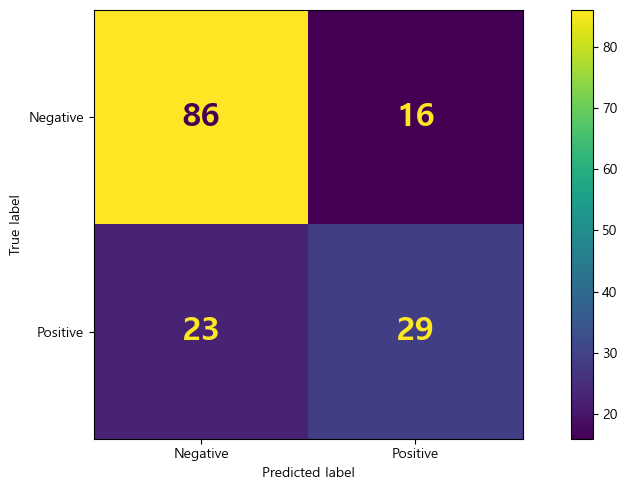


[Roc Curve]


[scatterd] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


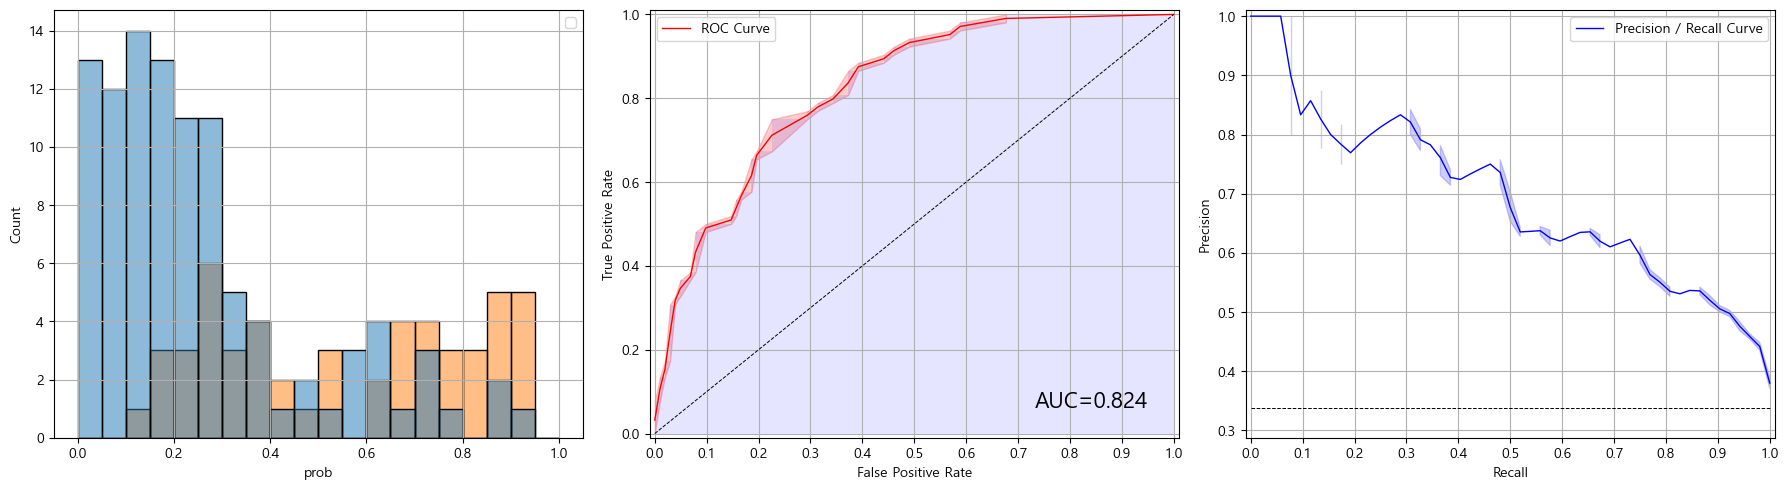


[학습곡선]


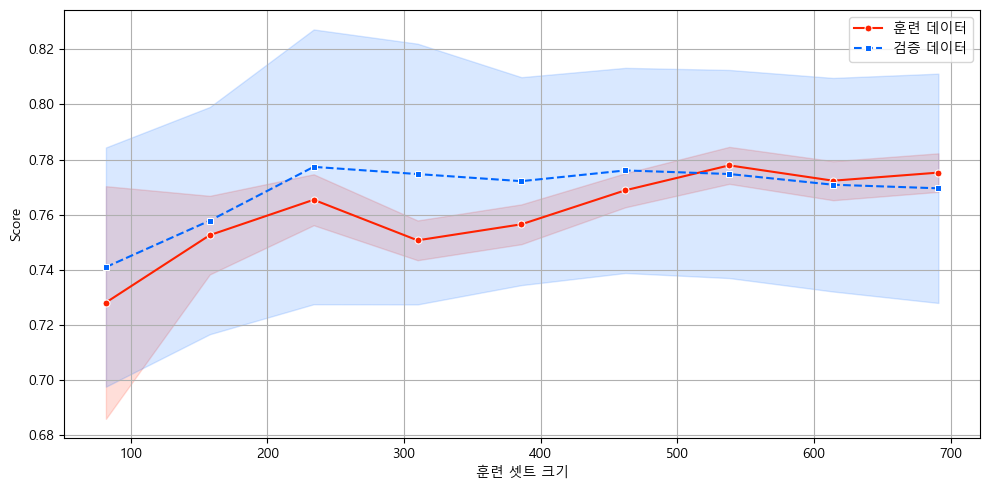

+----+---------+------------+--------------------------+--------------------+------------+--------+------------+---------+------------+
|    |   index | 종속변수   | 독립변수                 |   B(비표준화 계수) |   표준오차 |      t |   유의확률 |     VIF |   OddsRate |
|----+---------+------------+--------------------------+--------------------+------------+--------+------------+---------+------------|
|  0 |       7 | Outcome    | Age                      |             0.1002 |       0.31 | 0.3236 |      0.746 | 2.05027 |     1.1054 |
|  1 |       5 | Outcome    | BMI                      |              0.643 |      0.265 |  2.425 |      0.015 | 1.76203 |     1.9022 |
|  2 |       0 | Outcome    | Pregnancies              |             0.4551 |       0.27 | 1.6838 |      0.092 | 1.72987 |     1.5763 |
|  3 |       3 | Outcome    | SkinThickness            |             0.0475 |      0.266 | 0.1783 |      0.858 |  1.4874 |     1.0487 |
|  4 |       2 | Outcome    | BloodPressure            |            -0

{'LogisticRegression': LogisticRegression(max_iter=1000, n_jobs=1, random_state=1000),
 'GaussianNB': GaussianNB(),
 'DecisionTreeClassifier': DecisionTreeClassifier(criterion='entropy', random_state=1000),
 'SGDClassifier': SGDClassifier(early_stopping=True, n_jobs=2, random_state=1000),
 'KNeighborsClassifier': KNeighborsClassifier(n_jobs=2),
 'SVC': SVC(max_iter=1000, n_jobs=2, probability=True, random_state=1000),
 'best': LogisticRegression(max_iter=1000, n_jobs=1, random_state=1000)}

In [17]:
best_estimator = my_classification(x_train=x_train, y_train=y_train, x_test=x_test, y_test=y_test, pruning=False)
best_estimator

### [3] Bagging 모형 구현

[분류분석 성능평가]
+-------------------+--------------+--------------+-----------------------------------------------------------+
|                   |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------+--------------+--------------+-----------------------------------------------------------|
| 정확도(Accuracy)  |     0.685668 |     0.688312 | 예측 결과(TN,FP,TP,TN)가 실제 결과(TP,TN)와 일치하는 정도 |
| 정밀도(Precision) |     0.848485 |     0.833333 | 양성으로 예측한 결과(TP,FP) 중 실제 양성(TP)인 비율       |
| 재현율(Recall)    |      0.12963 |    0.0961538 | 실제 양성(TP,FN) 중 양성(TP)으로 예측한 비율              |
| 위양성율(Fallout) |    0.0125628 |   0.00980392 | 실제 음성(FP,TN) 중 양성(FP)으로 잘못 예측한 비율         |
| 특이성(TNR)       |     0.987437 |     0.990196 | 실제 음성(FP,TN) 중 음성(TN)으로 정확히 예측한 비율       |
| F1 Score          |       0.2249 |     0.172414 | 정밀도와 재현율의 조화평균                                |
| AUC               |     0.837975 |     0.803733 | ROC Curve의 면적으로, 1에 가까울수록 좋은 모델            |
+--

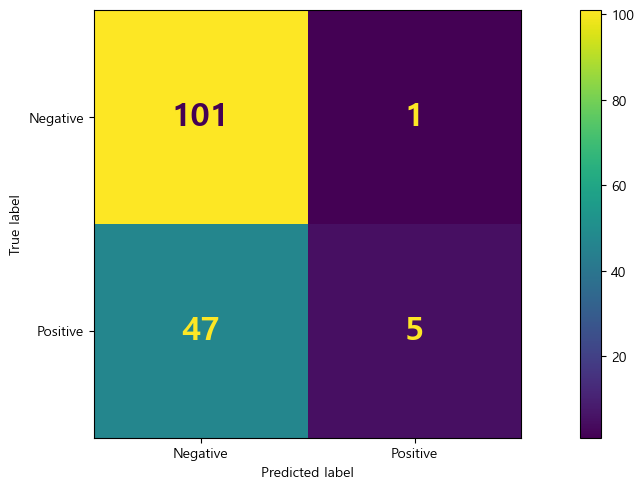


[Roc Curve]


[scatterd] >WARNING> No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


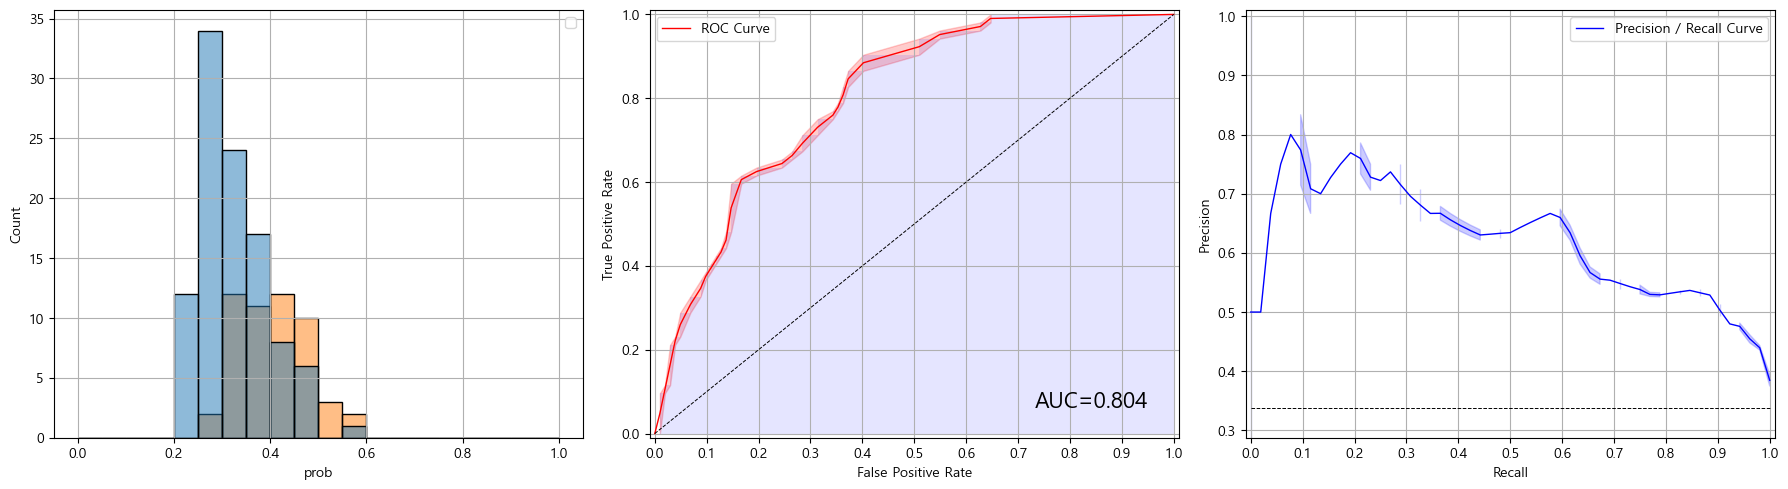


[학습곡선]


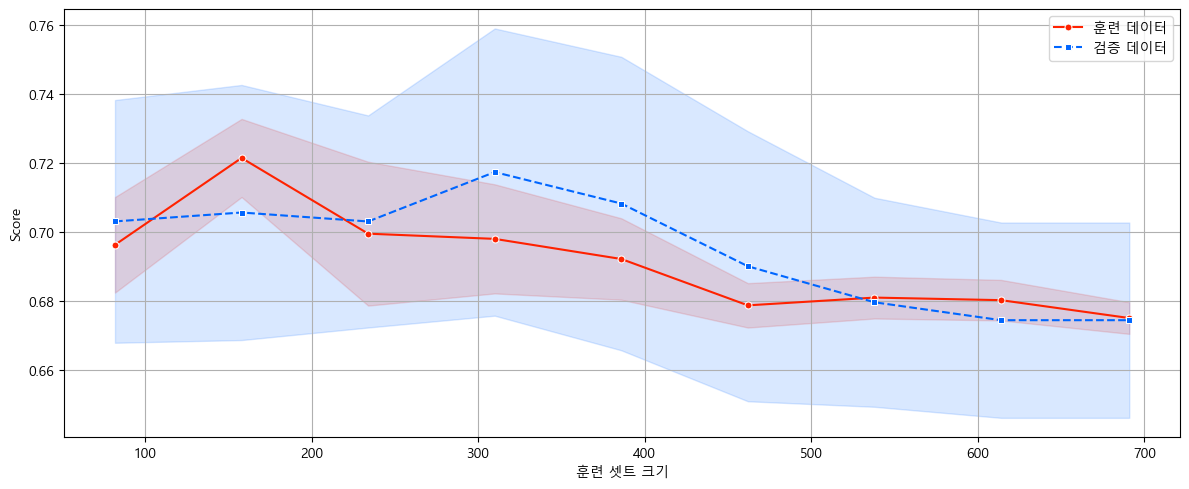

In [18]:
bagging = BaggingClassifier(estimator=best_estimator['best'],
                            n_estimators=10,
                            bootstrap=True,
                            random_state=get_random_state(),
                            bootstrap_features=False,
                            n_jobs=get_n_jobs())

bagging.fit(x_train, y_train)

my_classification_result(estimator=bagging,x_train=x_train, y_train= y_train, x_test=x_test, y_test=y_test)
                    